In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])
# use the same number of mice per age - only age 80

/tmp/ipykernel_2691/4054637843.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_2691/4054637843.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

data = data=pd.concat([m_data,f_data])

In [9]:
df=m_norm

In [10]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")
boot_df_m=boot_df.copy()

In [18]:
abs_diff

syllables,0,2,4,5,6,7,9,10,11,12,...,77,79,83,84,85,90,93,95,97,98
age,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.016356,0.041847,0.069415,0.019478,0.054991,0.009987,0.030869,0.016014,0.040814,0.081392,...,0.035422,0.044834,0.017256,0.050738,0.063343,0.034343,0.010317,0.010128,0.061592,0.030116
12,0.005422,0.003493,0.048825,0.049609,0.007409,0.032228,0.029997,0.014186,0.066087,0.078284,...,0.012628,0.030814,0.032888,0.007412,0.045593,0.056117,0.001924,0.011649,0.037918,0.004068
20,0.007260,0.022837,0.070408,0.058740,0.009436,0.038204,0.048829,0.027866,0.081734,0.113909,...,0.030549,0.057679,0.039134,0.021568,0.068204,0.059939,0.008537,0.020341,0.061456,0.024274
24,0.015863,0.014665,0.041255,0.067661,0.056852,0.005276,0.055544,0.051115,0.051302,0.096435,...,0.022302,0.026101,0.019145,0.008515,0.015137,0.048009,0.030751,0.020462,0.010647,0.002794
28,0.012866,0.004084,0.006280,0.050865,0.052599,0.011979,0.025637,0.020186,0.038294,0.030491,...,0.014559,0.051897,0.035136,0.008611,0.009011,0.043592,0.009311,0.015583,0.035741,0.009158
32,0.015308,0.018976,0.004054,0.024723,0.029064,0.030610,0.014677,0.027795,0.038817,0.024744,...,0.024040,0.021572,0.030658,0.022783,0.014120,0.022961,0.007295,0.017105,0.001557,0.008028
36,0.015677,0.011431,0.028760,0.000928,0.003410,0.002189,0.018878,0.013780,0.011767,0.010918,...,0.038110,0.028256,0.010113,0.019031,0.004556,0.002495,0.009867,0.005396,0.013369,0.026391
40,0.004624,0.020087,0.001209,0.006244,0.023687,0.017982,0.022300,0.005174,0.027209,0.010609,...,0.008699,0.000040,0.034627,0.005854,0.003784,0.020286,0.009474,0.014029,0.016512,0.006682


In [12]:
avg_usage

syllables,0,2,4,5,6,7,9,10,11,12,...,77,79,83,84,85,90,93,95,97,98
age,,,,,,,,,,,,,,,,,,,,,
4,0.153068,0.194748,0.041501,0.147311,0.152859,0.147384,0.527174,0.328577,0.615530,0.659009,...,0.038055,0.032690,0.123468,0.135183,0.603132,0.027323,0.167921,0.437596,0.026039,0.079486
8,0.173112,0.482800,0.109010,0.140292,0.430399,0.286192,0.670185,0.419383,0.564444,0.766213,...,0.201960,0.126422,0.153668,0.181825,0.336527,0.137054,0.167411,0.366646,0.144582,0.151655
12,0.202529,0.330515,0.320889,0.225328,0.439448,0.383673,0.531547,0.309856,0.378833,0.371962,...,0.313145,0.148612,0.187341,0.224019,0.295444,0.142826,0.218885,0.379127,0.152603,0.122891
20,0.245474,0.506519,0.421047,0.245489,0.519164,0.223885,0.401214,0.270691,0.395976,0.269938,...,0.260129,0.300461,0.222703,0.423325,0.196046,0.241974,0.219987,0.364314,0.393885,0.265781
24,0.176403,0.282368,0.309427,0.447541,0.159079,0.421847,0.435502,0.294713,0.201333,0.285641,...,0.158868,0.214972,0.331022,0.133444,0.264437,0.397991,0.169431,0.342588,0.240271,0.093260
28,0.190868,0.401626,0.392692,0.388870,0.322754,0.367186,0.338949,0.210127,0.241351,0.150334,...,0.268297,0.341285,0.292591,0.260041,0.207858,0.282515,0.222778,0.317999,0.338831,0.237581
32,0.295842,0.397687,0.368545,0.470508,0.180379,0.289948,0.386874,0.124856,0.328233,0.231518,...,0.388256,0.226507,0.210361,0.165744,0.263849,0.358148,0.377124,0.532870,0.159440,0.151220
36,0.261192,0.383716,0.369837,0.467918,0.216904,0.442774,0.388633,0.260203,0.150742,0.215675,...,0.329135,0.498166,0.430851,0.260216,0.216452,0.398247,0.198123,0.204997,0.474593,0.207124
40,0.286960,0.336710,0.424826,0.382555,0.329815,0.430090,0.316990,0.120612,0.147572,0.123757,...,0.317092,0.335328,0.394286,0.234488,0.299641,0.377800,0.224879,0.273100,0.332239,0.178049


In [11]:
df=f_norm

In [12]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")
boot_df_f=boot_df.copy()

In [13]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

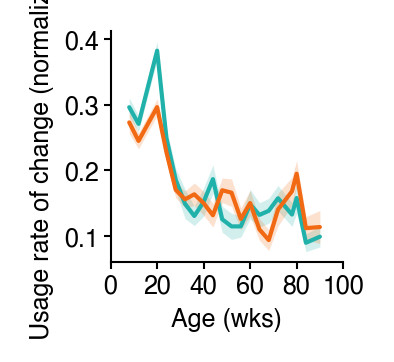

In [14]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    errorbar=("sd"),
    err_kws=dict(lw=0),
    color='#20B2AA',
)
ax = sns.lineplot(
    data=boot_df_f,
    x="age",
    y="value",
    errorbar=("sd"),
    err_kws=dict(lw=0),
    color='#f16913',
)

ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)", xticks = [0,20,40,60,80,100])
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_aging_rate.pdf')